FreeGS free boundary solver
========================

A free boundary Grad-Shafranov solver, written in python.

 - Available on [github](https://github.com/bendudson/freegs.git)
 - Manual on [Readthedocs](http://freegs.readthedocs.io/en/latest/)

Install FreeGS from [PyPI](https://pypi.org/project/FreeGS/) by running in a terminal:
```bash
$ pip install --user freegs
```
(here using version 0.4.0)

Solves

$$
\Delta^* \psi\left(R,Z\right) = -\mu_0RJ_\phi\left(R,Z\right)
$$

where the toroidal current density is 

$$
J_\phi = R\frac{dp\left(\psi\right)}{d\psi} + \frac{1}{\mu_0 R}f\left(\psi\right)\frac{d f\left(\psi\right)}{d\psi}
$$

In [1]:
import freegs

Define the poloidal field coils and their locations in (R,Z)

[Coils](https://github.com/bendudson/freegs/blob/master/freegs/machine.py#L88) can also be given a current, number of turns (default 1), areas (default based on current limit): 

If needed, coils can be grouped into [Circuit](https://github.com/bendudson/freegs/blob/master/freegs/machine.py#L282)s. See for example the [MAST_sym](https://github.com/bendudson/freegs/blob/master/freegs/machine.py#L811) machine definition.

In [2]:
from freegs.machine import Coil, Machine

coils = [("P1L", Coil(1.0, -1.1)),
         ("P1U", Coil(1.0, 1.1)),
         ("P2L", Coil(1.75, -0.6)),
         ("P2U", Coil(1.75, 0.6))]

tokamak = Machine(coils)

Plasma profiles
----------------------

Specify the profiles $p\left(\psi\right)$ and $f\left(\psi\right)$ which determine the plasma current:

$$
J_\phi = R\frac{dp\left(\psi\right)}{d\psi} + \frac{1}{\mu_0 R}f\left(\psi\right)\frac{d f\left(\psi\right)}{d\psi}
$$

YoungMu Jeon [arXiv:1503.03135](https://arxiv.org/abs/1503.03135)

$$
J_\phi = \lambda \left(\beta_0 \frac{R}{R_0} + \left(1-\beta_0\right)\frac{R_0}{R}\right) \tilde{j}
$$

where $\tilde{j}$ is a shape function which depends on the normalised flux $0 \le \psi_n \le 1$ inside the plasma:

$$
\psi_n = \frac{\psi - \psi_{axis}}{\psi_{boundary} - \psi_{axis}}
$$

The shape function $\tilde{j}$ is chosen to be 

$$
\tilde{j} = \left(1 - \psi_n^{\alpha_m}\right)^{\alpha_n}
$$

where $\alpha_m$ and $\alpha_n$ are constants.

The values $\beta_0$ and $L$ are set using two constraints:
 
 * Maximum plasma pressure, and plasma current: [ConstrainPaxisIp](https://github.com/bendudson/freegs/blob/master/freegs/jtor.py#L276)
 * Poloidal beta, and plasma current: [ContrainBetapIp](https://github.com/bendudson/freegs/blob/master/freegs/jtor.py#L125)

In [3]:
profiles = freegs.jtor.ConstrainPaxisIp(1e3, # Plasma pressure on axis [Pascals]
                                        3e5, # Plasma current [Amps]
                                        2.0) # Vacuum f=R*Bt

Shape control
--------------------

The shape of the plasma is controlled by adjusting the currents in the poloidal field coils. 

In [32]:
# Coil current constraints
#
# Specify locations of the X-points
# to use to constrain coil currents

xpoints = [(1.1, -0.6),   # (R,Z) locations of X-points
           (1.1, 0.8)]

isoflux = [(1.1,-0.6, 1.1,0.6)] # (R1,Z1, R2,Z2) pair of locations

constrain = freegs.control.constrain(xpoints=xpoints, isoflux=isoflux)

In [33]:
eq = freegs.Equilibrium(tokamak=tokamak,
                        Rmin=0.1, Rmax=2.0,    # Radial domain
                        Zmin=-1.0, Zmax=1.0,   # Height range
                        nx=65, ny=65,          # Number of grid points
                        boundary=freegs.boundary.freeBoundaryHagenow)  # Boundary condition

freegs.solve(eq,          # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain)   # Constraint function to set coil currents

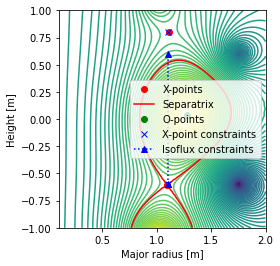

In [35]:
%matplotlib inline
from freegs.plotting import plotEquilibrium, plotConstraints

axis = plotEquilibrium(eq, show=False)
plotConstraints(constrain, axis=axis)

In [11]:
# Currents in each of the coils and circuits
tokamak.printCurrents()

P1L : Coil(R=1.0, Z=-1.1, current=233997.5, turns=1, control=True)
P1U : Coil(R=1.0, Z=1.1, current=93538.3, turns=1, control=True)
P2L : Coil(R=1.75, Z=-0.6, current=-150168.2, turns=1, control=True)
P2U : Coil(R=1.75, Z=0.6, current=-82321.9, turns=1, control=True)


Forces on the coils
-------------------

The [force on each coil](https://github.com/bendudson/freegs/blob/master/freegs/machine.py#L167) is due to the current it carries, and the magnetic field from a combination of

 * The plasma poloidal field
 * The other coils
 * Itself. This is the hoop force, which is in the outwards ($R$) direction. The magnitude of this hoop force depends on the cross-section area and self-inductance of the coil.

$$
F_{hoop} = \frac{\mu_0}{4\pi R} I^2 \left[\ln\left(8R/a\right) - 1 + \xi/2\right]
$$

where $a$ is the minor radius of the (circular) coil, and $\xi$ is the internal inductance. $\xi=1/2$ for a uniform current distribution (used here), and $\xi=0$ for a surface current.

In FreeGS by default the minor radius $a$ is calculated from the area, assuming a circular coil. The area can be specified in m$^2$ e.g. `tokamak["P1L"].area = 0.01` but by default is calculated using a typical maximum current density for Nb3Sn (3.5e9 A/m$^2$) [from here](https://doi.org/10.1016/0167-899X(86)90010-8).


References: 

1. David A. Garren and James Chen [Lorentz self‐forces on curved current loops](https://doi.org/10.1063/1.870491) Physics of Plasmas 1, 3425 (1998); 

        

In [12]:
eq.printForces()

Forces on coils
P1L : R = 218.79 kN , Z = 29.30 kN
P1U : R = 50.03 kN , Z = -18.26 kN
P2L : R = 143.88 kN , Z = -27.65 kN
P2U : R = 55.25 kN , Z = 22.00 kN


Safety factor
------------------

This is the number of toroidal turns a magnetic field line makes after one poloidal turn. It is calculated [here](https://github.com/bendudson/freegs/blob/master/freegs/critical.py#L428) by integrating

$$
q = \frac{1}{2\pi}\int_0^{2\pi}\frac{\mathbf{B}\cdot\nabla\phi}{\mathbf{B}\cdot\nabla\theta}d\theta
$$

then using $\mathbf{B}\cdot\nabla\theta = B_\theta \frac{d\theta}{dl_\theta}$ where $l_\theta$ is the distance in the poloidal direction along a flux surface:

$$
q = \frac{1}{2\pi}\oint\frac{B_\phi}{RB_\theta}dl_\theta
$$




Safety factor:
	psi 	 q
	0.01	0.90
	0.90	4.19
	0.95	5.10


Text(0, 0.5, 'Safety factor $q$')

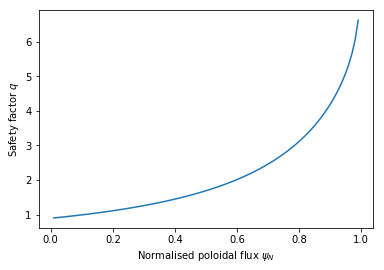

In [9]:
import matplotlib.pyplot as plt

print("\nSafety factor:\n\tpsi \t q")
for psi in [0.01, 0.9, 0.95]:
    print("\t{:.2f}\t{:.2f}".format(psi, eq.q(psi)))

plt.plot(*eq.q())
plt.xlabel(r"Normalised poloidal flux $\psi_N$")
plt.ylabel(r"Safety factor $q$")

In [10]:
eq.plasmaCurrent()  # Plasma current [Amps]

300000.00000000006

In [11]:
eq.poloidalBeta()

0.02019942296535706